In [50]:
import matplotlib.pyplot as plt
import numpy as np

from freq_stacking_LFM_ACF_utils import *

from scipy.fft import fft, ifft, fftfreq, fftshift
import scipy.signal

from tensorforce.environments import Environment
from tensorforce.agents import Agent

# Define Constant parameters

In [51]:
# min and max RF center freqs in Hz
fc_min = 500e6
fc_max = 1.48e9
delta_f = 5e6

# min and max Bws in Hz
Bmin = 18e6
Bmax = 20e6
delta_B = 1e6


max_delay_time = 5e-6
delay_time = 0.0

# chirp rate
chirp_rate = 50e6/10e-6


num_subpulses = 50

# maximum episode length
max_episode_timesteps = 3000

training_num = 200



# Derived Parameters

In [52]:
Fs_baseband = Bmax  # baseband samp freq in Hz
Fs_SWW_max = fc_max + Bmax / 2 - (fc_min - Bmax / 2)

# time window size
max_subpulse_duration = Bmax / chirp_rate
time_window_size = 10 * max_subpulse_duration + max_delay_time


# compute the state vector size
LFM_rx_subpulses, LFM_ref_subpulses = generate_LFM_rx_ref_subpulses_for_ACF(
    BW_RF_array=np.array([20e6]),
    chirp_rate=chirp_rate,
    time_window_size=time_window_size,
    Fs_baseband=Fs_baseband
)

N_max = compute_Nup_f(LFM_rx_subpulses[0], Fs_baseband, Fs_SWW_max) # the state vector size

# num_subpulses = int( Fs_SWW_max / Bmax * 1.2) # number of subpulses: may be a little bit larger than the none-overlapping case


# Radar Environment Setup

In [53]:
class ACF_Env(Environment):

    ####################################################################
    # Required methods defs
    ####################################################################
    def __init__(
        self,
        num_subpulses,
        fc_min,
        fc_max,
        delta_f,
        Bmin,
        Bmax,
        delta_B,
        chirp_rate,
        time_window_size,
        Fs_baseband,
    ):
        super().__init__()
        
        self.num_subpulses = num_subpulses
        self.fc_min = fc_min
        self.fc_max = fc_max
        self.delta_f = delta_f,
        self.Bmin = Bmin
        self.Bmax = Bmax
        self.delta_B = delta_B,
        self.chirp_rate = chirp_rate

        self.time_window_size = time_window_size
        self.Fs_baseband = Fs_baseband

        self._current_best_sww_performance = 0 # the ISLR or PSL, i.e. the criteria of the waveform

    def states(self):
        return dict(
            type="float", shape=(2, self.num_subpulses)
        )  # the first row is the RF center freqs, and the second row is the BWs;
        # the actions are normalized to [0, 1]

    def actions(self):
        return dict(
            type="float", shape=(2, self.num_subpulses), min_value=-1, max_value=1
        )  


    def reset(self):
        """Reset state."""
        # state = np.random.random(size=(1,))
        self.timestep = 0
        self.current_state = np.zeros((2, self.num_subpulses))
        self.current_state[0] = self.fc_min + np.arange(self.num_subpulses) * self.Bmax
        self.current_state[1] =self.Bmax

        return self.current_state

    def execute(self, actions):
        """[summary] Executes the given action(s) and advances the environment by one step.

        The execute method implements the "simulator": how the environment reacts to an action
            1. Increment timestamp
            2. Update the current state: next_state <-- f(current_state, actions) (implement state transition)
            3. Compute the reward accociated with the new state

        returns state, terminal, reward
        """

        # increment timestep
        self.timestep += 1

        # compute the next ACF and next reward
        next_state, next_reward = self.compute_next_state_and_reward(actions)

        # update the current ACF and reward
        self.current_state = next_state
        reward = next_reward

        terminal = False  # maybe implement like this: if converge, terminal = True

        return self.current_state, terminal, reward

    ####################################################################
    # Helper functions
    ####################################################################

    # helper function that implements the env model/simulator
    def compute_next_state_and_reward(self, actions):
        """[summary] this method implements how env reacts to action:
            action --> state

            and also computes the reward associated with the state

        Args:
            actions ([type]): [description] the normalized actions

        Returns:
            [type]: [description] the the next_state and next_reward
        """
        
        next_state = np.zeros_like(actions)
        next_state[0] = self.current_state[0] + self.delta_f * actions[0] # compute center freqs
        next_state[1] = self.current_state[1] + self.delta_B * actions[1] # compute BWs

        # make sure all center freqs and BWs are within range
        next_state[0, next_state[0] > self.fc_max] = self.fc_max
        next_state[0, next_state[0] < self.fc_max] = self.fc_min
        next_state[1, next_state[1] > self.Bmax] = self.Bmax
        next_state[1, next_state[1] < self.Bmin] = self.Bmin


        # the following code computes the waveform performance associated with the next_state
        fc_RF_freqs = next_state[0]  # the first row is the RF center freqs
        BW_RF_array = next_state[1]  # the second row is the BWs
        

        # compute the time domain subpulses
        LFM_rx_subpulses, LFM_ref_subpulses = generate_LFM_rx_ref_subpulses_for_ACF(
            BW_RF_array, self.chirp_rate, self.time_window_size, self.Fs_baseband
        )

        # filter BWs
        Bs_array = BW_RF_array

        # apply freq. stacking and get ACF
        _, d_t = freq_stacking(
            LFM_rx_subpulses,
            LFM_ref_subpulses,
            fc_RF_freqs,
            BW_RF_array,
            Bs_array,
            self.Fs_baseband,
        )

        # compute ACF
        ACF = np.abs(d_t) / np.max(np.abs(d_t))

        # compute the sww_performance associated with this ACF
        sww_performance = -int_sidelobe_ratio(ACF)
        reward =  sww_performance - self._current_best_sww_performance

        # update the max score
        if sww_performance > self._current_best_sww_performance:
            self._current_best_sww_performance = sww_performance
        
        if sww_performance > 22.9:
            print(f"-ISLR = {sww_performance}")

        return next_state, reward

    ####################################################################
    # Optional methods defs
    ####################################################################

    # Optional, should only be defined if environment has a natural maximum
    # episode length
    def max_episode_timesteps(self):
        return super().max_episode_timesteps()

    # Optional
    def close(self):
        super().close()


In [54]:
# create an ACF_env


my_ACF_Env = Environment.create(
    environment=ACF_Env,
    max_episode_timesteps=max_episode_timesteps,
    num_subpulses = num_subpulses,
    fc_min=fc_min,
    fc_max=fc_max,
    delta_f = delta_f,
    Bmin=Bmin,
    Bmax=Bmax,
    delta_B = delta_B,
    chirp_rate=chirp_rate,
    time_window_size=time_window_size,
    Fs_baseband=Fs_baseband,
)


# Agent Setup

 Here we configure a type of agent to learn against this environment. There are many agent configurations to choose from, which we will not cover here. We will not discuss what type of agent to choose here -- we will just take a basic agent to train.

In [55]:
agent = Agent.create(
    agent='tensorforce', environment=my_ACF_Env, update=64,
    optimizer=dict(optimizer='adam', learning_rate=1e-3),
    objective='policy_gradient', reward_estimation=dict(horizon=1)
)

# Check: Untrained Agent Performance
The agent just initializes a policy and use that policy

# Train the agent

In [56]:
# Train for 200 episodes

for _ in range(training_num):
    states = my_ACF_Env.reset()
    terminal = False
    print(f"{_} iteration")
    time = 0
    while not terminal:
        actions = agent.act(states=states)
        states, terminal, reward = my_ACF_Env.execute(actions=actions)
        agent.observe(terminal=terminal, reward=reward)
        time += 1
        #print(f"time = {time}")

0 iteration
1 iteration


KeyboardInterrupt: 

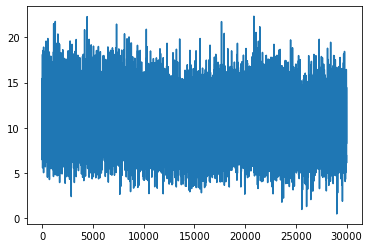

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline


plt.plot(reward_list)

plt.show()

In [ ]:
num_subpulses, np.max(reward_list)

(50, 22.32894055735685)

# Trained Agent Performance